## DASK_ML

In [1]:
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LinearRegression
from dask_ml.wrappers import Incremental
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

import xgboost as xgb
from dask.distributed import Client
from dask.distributed import LocalCluster
from dask_jobqueue import SLURMCluster
import pandas as pd
import joblib
import numpy as np
import time
from dask.delayed import delayed
from itertools import product
import matplotlib.pyplot as plt

In [2]:
# Initialize Dask client
cluster = LocalCluster(n_workers=64, threads_per_worker=2, memory_limit="2GB")
client = Client(cluster)
print(client)

<Client: 'tcp://127.0.0.1:45889' processes=64 threads=128, memory=119.21 GiB>


In [3]:
# Load data
files_to_use = "parquet"
# files_to_use = "hdf5" # does not work

if files_to_use == "parquet":
    start_time = time.time()
    data = dd.read_parquet('/d/hpc/projects/FRI/bigdata/students/dp8949/parquet_data/*.parquet')
    end_time = time.time()

elif files_to_use == "hdf5":
    start_time = time.time()
    data = dd.read_hdf('/d/hpc/projects/FRI/bigdata/students/dp8949/hdf5_data/*.h5', '/*')
    end_time = time.time()
else:
    print("No data files found")
    exit(1)

with open('results_comparison.txt', 'a') as f:
    f.write("-"*50 + "\n")
    f.write(f"Data loaded from {files_to_use} files\n")
    f.write(f"Data shape: {data.shape}\n")
    f.write("-"*50 + "\n\n")
    f.write(f"{'Task':<35}{'Time':<10}\n")
    f.write(f"{'Data reading':<35}{(end_time - start_time):<10.2f}\n")
    

# print all columns and their data types
print(data.dtypes)

Summons Number                                 int64
Plate ID                             string[pyarrow]
Registration State                   string[pyarrow]
Plate Type                           string[pyarrow]
Issue Date                           string[pyarrow]
Violation Code                                 int64
Vehicle Body Type                    string[pyarrow]
Vehicle Make                         string[pyarrow]
Issuing Agency                       string[pyarrow]
Street Code1                                   int64
Street Code2                                   int64
Street Code3                                   int64
Vehicle Expiration Date              string[pyarrow]
Violation Location                           float64
Violation Precinct                             int64
Issuer Precinct                                int64
Issuer Code                                    int64
Issuer Command                       string[pyarrow]
Issuer Squad                         string[py

### Data Cleaning

In [4]:
def data_cleaning(data):
    # keep only the columns we need
    columns_to_keep = [
        'Violation County',
        'Issue Date',
        'Violation Time',]

    data = data[columns_to_keep]

    # rename columns to remove spaces and make them lowercase
    data = data.rename(columns={
        'Violation County': 'violation_county',
        'Issue Date': 'issue_date',
        'Violation Time': 'violation_time'
    })

    # fix the county names
    remap_county_dict = {
        'K' : 'Brooklyn',
        'Q' : 'Queens',
        'NY': 'Manhattan',
        'QN': 'Queens',
        'BK': 'Brooklyn',
        'R' : 'Staten Island',
        'BX': 'Bronx',
        'ST': 'Staten Island',
        'MN': 'Manhattan',
        'KINGS': 'Brooklyn',
        'QNS': 'Queens',
        'BRONX': 'Bronx'
    }
    data['violation_county'] = data['violation_county'].map(remap_county_dict, meta=('violation_county', 'category')).astype('category')

    # convert the Issue Date to a datetime object
    data['issue_date'] = dd.to_datetime(data['issue_date'], format='%m/%d/%Y', errors='coerce')

    # Remove 'A' and 'P' from the end of the time, add ' AM' or ' PM' accordingly
    data['violation_time'] = data['violation_time'].str.slice(stop=-1) + ' ' + data['violation_time'].str.slice(start=-1).replace({'A': 'AM', 'P': 'PM'})

    # Convert the Violation Time to a datetime object
    data['violation_time'] = dd.to_datetime(data['violation_time'], format='%I%M %p', errors='coerce')

    # create a new column for the day of the week the violation was issued
    data['violation_day_week'] = data['issue_date'].dt.dayofweek

    # create a new column for the day of the month the violation was issued
    data['violation_day_month'] = data['issue_date'].dt.day

    # create a new column for the month the violation was issued
    data['violation_month'] = data['issue_date'].dt.month

    # create a new column for the year the violation was issued
    data['violation_year'] = data['issue_date'].dt.year

    # keep only rows with valid year (2013-2024)
    data = data[(data['violation_year'] >= 2013) & (data['violation_year'] <= 2024)]

    # keep only rows with valid month (1-12)
    data = data[(data['violation_month'] >= 1) & (data['violation_month'] <= 12)]

    # drop all rows with missing values
    data = data.dropna()

    # create a new column for the hour of the day the violation was issued
    data['violation_hour'] = data['violation_time'].dt.hour.astype('int32')

    # drop the Issue Date and Violation Time columns
    data = data.drop(columns=['violation_time'])


    # remove COVID-19 pandemic months since there were no parking tickets issued
    pandemic_start = '2019-07'
    pandemic_end = '2020-06'

    data = data[(data['issue_date'] < pandemic_start) | (data['issue_date'] > pandemic_end)]
    
    return data

start_time = time.time()
data = data_cleaning(data)

# save the time to results_comparison.txt
with open('results_comparison.txt', 'a') as f:
    f.write(f"{'Data Cleaning':<35}{time.time() - start_time:<10.2f}\n")

In [5]:
#print type of columns
print(data.dtypes)

violation_county             category
issue_date             datetime64[ns]
violation_day_week              int32
violation_day_month             int32
violation_month                 int32
violation_year                  int32
violation_hour                  int32
dtype: object


In [6]:
# Group by day and county and count the number of violations
monthly_violations = data.groupby(['violation_month', 'violation_year', 'violation_county'], observed=False).size().reset_index()
# daily_violations = data.groupby(['violation_day_month', 'violation_month', 'violation_year', 'violation_county'], observed=False).size().reset_index()
monthly_violations = monthly_violations.rename(columns={0: 'num_violations'})

# Convert the day, month, and year columns to integers
# daily_violations['violation_day_month'] = daily_violations['violation_day_month'].astype(int)
# daily_violations['violation_month'] = daily_violations['violation_month'].astype(int)
# daily_violations['violation_year'] = daily_violations['violation_year'].astype(int)

monthly_violations['violation_month'] = monthly_violations['violation_month'].astype(int)
monthly_violations['violation_year'] = monthly_violations['violation_year'].astype(int)

# Combine the day, month, and year columns into a single column and delete the individual columns
monthly_violations['violation_date'] = monthly_violations['violation_year'].astype(str) + '-' + monthly_violations['violation_month'].astype(str).astype(str)
# daily_violations['violation_date'] = daily_violations['violation_year'].astype(str) + '-' + daily_violations['violation_month'].astype(str) + '-' + daily_violations['violation_day_month'].astype(str)

# Print the intermediate violation_date column to debug
print(monthly_violations['violation_date'].compute())

# Convert the combined date column to datetime
monthly_violations['violation_date'] = dd.to_datetime(monthly_violations['violation_date'], format='%Y-%m', errors='coerce')

# Drop the individual day, month, and year columns
monthly_violations = monthly_violations.drop(columns=['violation_month', 'violation_year'])
# daily_violations = daily_violations.drop(columns=['violation_day_month', 'violation_month', 'violation_year'])

# Sort the data by date
monthly_violations = monthly_violations.sort_values(by='violation_date')

# Compute the result
monthly_violations = monthly_violations.compute()

# Print the final result to debug
print(monthly_violations)

0       2013-1
1       2013-1
2       2013-1
3       2013-1
4       2013-1
        ...   
715    2024-12
716    2024-12
717    2024-12
718    2024-12
719    2024-12
Name: violation_date, Length: 720, dtype: string
    violation_county  num_violations violation_date
0              Bronx             211     2013-01-01
1           Brooklyn             464     2013-01-01
2          Manhattan             510     2013-01-01
3             Queens             305     2013-01-01
4      Staten Island              32     2013-01-01
..               ...             ...            ...
715            Bronx              42     2024-12-01
716         Brooklyn              43     2024-12-01
717        Manhattan              25     2024-12-01
718           Queens              35     2024-12-01
719    Staten Island               2     2024-12-01

[720 rows x 3 columns]


In [7]:
print(monthly_violations.nlargest(10, 'num_violations'))

    violation_county  num_violations violation_date
413           Queens          948514     2023-07-01
473           Queens          845411     2023-08-01
411         Brooklyn          779519     2023-07-01
471         Brooklyn          768659     2023-08-01
472        Manhattan          762648     2023-08-01
533           Queens          689221     2023-09-01
412        Manhattan          688729     2023-07-01
531         Brooklyn          564656     2023-09-01
532        Manhattan          556702     2023-09-01
12         Manhattan          495757     2015-01-01


In [8]:
print(monthly_violations.head())

  violation_county  num_violations violation_date
0            Bronx             211     2013-01-01
1         Brooklyn             464     2013-01-01
2        Manhattan             510     2013-01-01
3           Queens             305     2013-01-01
4    Staten Island              32     2013-01-01


In [9]:
monthly_pivot = monthly_violations.pivot_table(index='violation_date', columns='violation_county', values='num_violations', fill_value=0).reset_index()
print(monthly_pivot.head())

/tmp/ipykernel_3576040/3198832920.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  monthly_pivot = monthly_violations.pivot_table(index='violation_date', columns='violation_county', values='num_violations', fill_value=0).reset_index()


violation_county violation_date  Bronx  Brooklyn  Manhattan  Queens  \
0                    2013-01-01  211.0     464.0      510.0   305.0   
1                    2013-02-01   51.0     113.0      132.0    66.0   
2                    2013-03-01   64.0     159.0      149.0    80.0   
3                    2013-04-01   37.0     138.0      158.0    81.0   
4                    2013-05-01   17.0      72.0      104.0    64.0   

violation_county  Staten Island  
0                          32.0  
1                          11.0  
2                          11.0  
3                          14.0  
4                           9.0  


In [10]:
print(monthly_pivot.nlargest(10, 'Queens'))

violation_county violation_date     Bronx  Brooklyn  Manhattan    Queens  \
126                  2023-07-01  358955.0  779519.0   688729.0  948514.0   
127                  2023-08-01  350051.0  768659.0   762648.0  845411.0   
128                  2023-09-01  279320.0  564656.0   556702.0  689221.0   
115                  2022-08-01  234480.0  467354.0   449076.0  487448.0   
125                  2023-06-01  201828.0  440297.0   379533.0  441010.0   
129                  2023-10-01  180303.0  348581.0   360527.0  402505.0   
124                  2023-05-01  200997.0  404030.0   388692.0  402312.0   
117                  2022-10-01  201309.0  414844.0   410004.0  392453.0   
116                  2022-09-01  192978.0  412701.0   387061.0  390080.0   
130                  2023-11-01  179506.0  335842.0   355554.0  385143.0   

violation_county  Staten Island  
126                    121047.0  
127                    119303.0  
128                     93091.0  
115                     719

## GEO PLOT

In [14]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import geodatasets
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

boros = gpd.read_file(geodatasets.get_path("nybb"))

# Find the global maximum of violations
max_violations = monthly_pivot.drop(columns='violation_date').values.max()

# if folder for plots does not exist, create it
if not os.path.exists('geo_plots'):
    os.makedirs('geo_plots')

In [94]:
def map_values_to_array(gdf, value_dict):
    return np.array([value_dict.get(boro, 0) for boro in gdf['BoroName']])


# Create a ScalarMappable for the colorbar
cmap = plt.cm.Reds
norm = plt.Normalize(vmin=0, vmax=max_violations)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for _, row in monthly_pivot.iterrows():
    print(row)
    month = row['violation_date'].strftime('%Y-%m')  # Format the month
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    boros.plot(ax=ax, color='white', edgecolor='black')
    
    # Merge the data for the month with the boroughs GeoDataFrame
    monthly_violations_gdf = boros.copy()
    monthly_violations_gdf['num_violations'] = map_values_to_array(monthly_violations_gdf, row.to_dict())
    
    # Check if the 'num_violations' column has been correctly populated
    print(monthly_violations_gdf[['BoroName', 'num_violations']])
    
    # Plot the merged data
    monthly_violations_gdf.plot(column='num_violations', ax=ax, legend=False, cmap='Reds', vmax=max_violations, vmin=0)
    
    # Create a colorbar with a specified aspect ratio
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label('Average Number of Violations')
    
    # Set the title
    fig.suptitle('NYC Parking Violations in {}'.format(month), fontsize=16)
    
    # Adjust layout to ensure the title is centered
    plt.tight_layout(rect=[0, 0, 1, 1.1])

    print(f"Mapping month {month}")
    # for county in monthly_violations_gdf['BoroName'].unique():
    #     print(f"   Violations in county {county}: {monthly_violations_gdf[monthly_violations_gdf['BoroName'] == county]['num_violations'].astype(int)}")

    # save plot to file
    plt.savefig('geo_plots/{}.png'.format(month))
    plt.close()

violation_county
violation_date    2013-01-01 00:00:00
Bronx                           211.0
Brooklyn                        464.0
Manhattan                       510.0
Queens                          305.0
Staten Island                    32.0
Name: 0, dtype: object
        BoroName  num_violations
0  Staten Island            32.0
1         Queens           305.0
2       Brooklyn           464.0
3      Manhattan           510.0
4          Bronx           211.0
Mapping month 2013-01
violation_county
violation_date    2013-02-01 00:00:00
Bronx                            51.0
Brooklyn                        113.0
Manhattan                       132.0
Queens                           66.0
Staten Island                    11.0
Name: 1, dtype: object
        BoroName  num_violations
0  Staten Island            11.0
1         Queens            66.0
2       Brooklyn           113.0
3      Manhattan           132.0
4          Bronx            51.0
Mapping month 2013-02
violation_county
violati

In [ ]:
# create a gif from the images
os.system('convert -delay 16 geo_plots/*[::5].png geo_plots/violations.gif')

## All-time daily average

In [12]:
# count ALL violations in every borough and divide by number of days to get daily average over the entire period
daily_average = data.groupby('violation_county').size() / data['issue_date'].nunique()
daily_average = daily_average.reset_index()
daily_average = daily_average.compute()

print(daily_average)

/d/hpc/home/bp58607/.conda/envs/bd39/lib/python3.9/site-packages/dask/dataframe/groupby.py:1450: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


  violation_county            0
0            Bronx  3932.160030
1         Brooklyn  8061.265555
2        Manhattan  9981.293927
3           Queens  7713.721005
4    Staten Island   870.490294


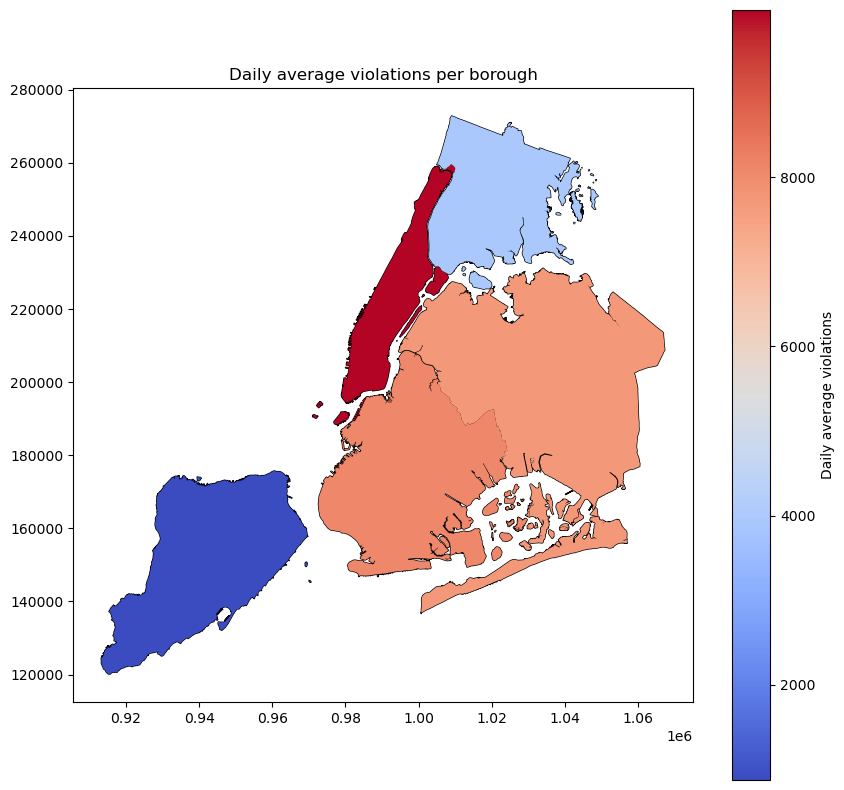

In [19]:
# map the daily average violations
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

daily_average_gdf = boros.merge(daily_average, left_on='BoroName', right_on='violation_county')

boros.plot(ax=ax, color='white', edgecolor='black')
daily_average_gdf.plot(ax=ax, column=0, legend=True, legend_kwds={'label': "Daily average violations"}, cmap='coolwarm')

plt.title('Daily average violations per borough')
plt.savefig('geo_plots/daily_average_violations.png')
plt.show()